In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [29]:
X_raw, y_raw = make_blobs(
    n_samples=1000,
    n_features=2,
    centers=5,
    cluster_std=1.5,
    random_state=42
)

# Scale data to avoid sigmoid saturation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
Y_encoded = encoder.fit_transform(y_raw.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, Y_encoded, test_size=0.2, random_state=42
)

In [30]:
class NeuralNetwork(object):
    def __init__(self):
        input_neurons = 2
        h1_neurons = 32
        h2_neurons = 32
        h3_neurons = 16
        output_neurons = 5

        self.learning_rate = 0.001

        self.W1 = np.random.randn(input_neurons, h1_neurons) * np.sqrt(1/input_neurons)
        self.W2 = np.random.randn(h1_neurons, h2_neurons) * np.sqrt(1/h1_neurons)
        self.W3 = np.random.randn(h2_neurons, h3_neurons) * np.sqrt(1/h2_neurons)
        self.W4 = np.random.randn(h3_neurons, output_neurons) * np.sqrt(1/h3_neurons)

    # Activation Functions
    def sigmoid(self, x, der=False):
        # Prevent overflow
        x = np.clip(x, -50, 50)
        s = 1 / (1 + np.exp(-x))
        return s * (1 - s) if der else s

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    # Forward Pass
    def feedForward(self, X):
        self.z1 = np.dot(X, self.W1)
        self.a1 = self.sigmoid(self.z1)

        self.z2 = np.dot(self.a1, self.W2)
        self.a2 = self.sigmoid(self.z2)

        self.z3 = np.dot(self.a2, self.W3)
        self.a3 = self.sigmoid(self.z3)

        self.z4 = np.dot(self.a3, self.W4)
        self.out = self.softmax(self.z4)
        return self.out

    # Backpropagation
    def backPropagation(self, X, Y, pred):
        # Softmax + cross-entropy gradient
        dZ4 = pred - Y
        dW4 = np.dot(self.a3.T, dZ4)

        dA3 = np.dot(dZ4, self.W4.T)
        dZ3 = dA3 * self.sigmoid(self.a3, der=True)
        dW3 = np.dot(self.a2.T, dZ3)

        dA2 = np.dot(dZ3, self.W3.T)
        dZ2 = dA2 * self.sigmoid(self.a2, der=True)
        dW2 = np.dot(self.a1.T, dZ2)

        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.sigmoid(self.a1, der=True)
        dW1 = np.dot(X.T, dZ1)

        # Gradient Descent updates
        self.W1 -= self.learning_rate * dW1
        self.W2 -= self.learning_rate * dW2
        self.W3 -= self.learning_rate * dW3
        self.W4 -= self.learning_rate * dW4

    # Training Step
    def train(self, X, Y):
        pred = self.feedForward(X)
        self.backPropagation(X, Y, pred)

Training...
Epoch 0: Loss = 1.6052
Epoch 500: Loss = 0.2499
Epoch 1000: Loss = 0.2641
Epoch 1500: Loss = 0.3289
Epoch 2000: Loss = 0.2674
Epoch 2500: Loss = 0.2883
Epoch 3000: Loss = 0.2402
Epoch 3500: Loss = 0.2923


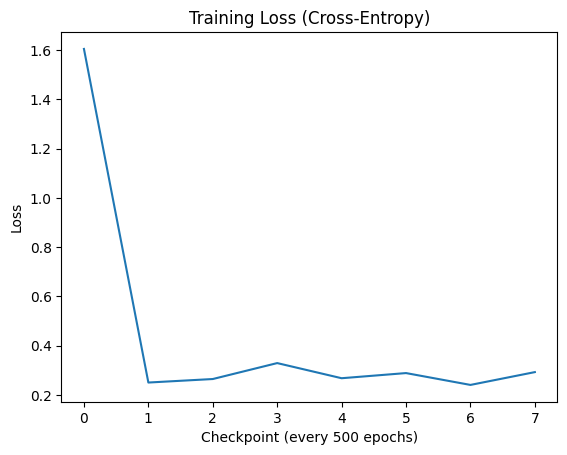

In [31]:
NN = NeuralNetwork()
losses = []

def cross_entropy(Y, pred):
    eps = 1e-12
    return -np.mean(np.sum(Y * np.log(pred + eps), axis=1))

print("Training...")

for epoch in range(4000):
    NN.train(X_train, y_train)

    if epoch % 500 == 0:
        pred = NN.feedForward(X_train)
        loss = cross_entropy(y_train, pred)
        losses.append(loss)
        print(f"Epoch {epoch}: Loss = {loss:.4f}")

# Ploting training loss
plt.plot(losses)
plt.title("Training Loss (Cross-Entropy)")
plt.xlabel("Checkpoint (every 500 epochs)")
plt.ylabel("Loss")
plt.show()


Accuracy: 0.9
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        41
           1       0.74      0.76      0.75        34
           2       1.00      1.00      1.00        47
           3       1.00      0.97      0.99        36
           4       0.79      0.74      0.77        42

    accuracy                           0.90       200
   macro avg       0.89      0.90      0.89       200
weighted avg       0.90      0.90      0.90       200



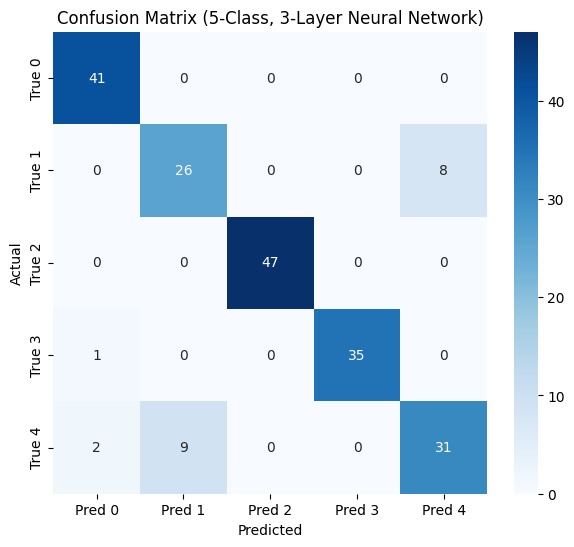

In [32]:
test_pred = NN.feedForward(X_test)
pred_labels = np.argmax(test_pred, axis=1)
true_labels = np.argmax(y_test, axis=1)

print("\nAccuracy:", accuracy_score(true_labels, pred_labels))
print(classification_report(true_labels, pred_labels))

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[f"Pred {i}" for i in range(5)],
    yticklabels=[f"True {i}" for i in range(5)]
)
plt.title("Confusion Matrix (5-Class, 3-Layer Neural Network)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



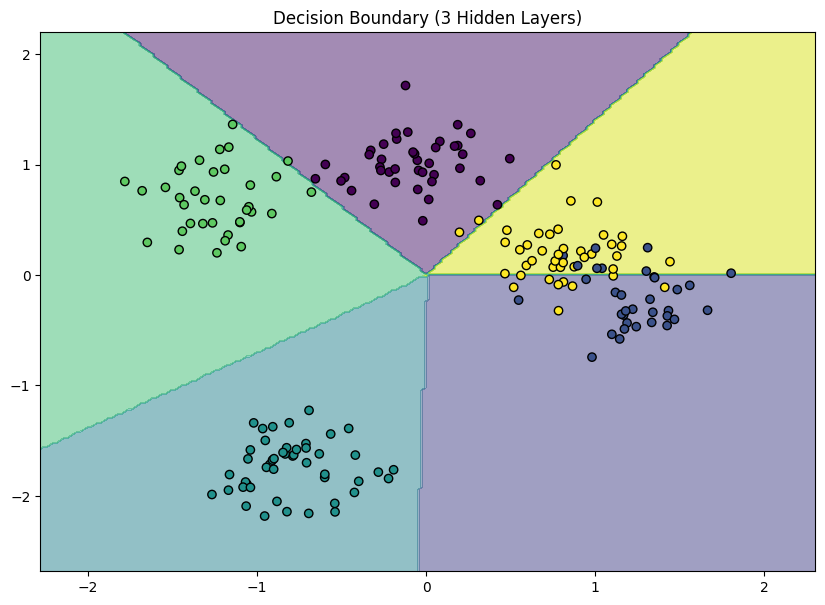

In [33]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.02

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )

    Z = model.feedForward(np.c_[xx.ravel(), yy.ravel()])
    Z = np.argmax(Z, axis=1).reshape(xx.shape)

    plt.figure(figsize=(10, 7))
    plt.contourf(xx, yy, Z, cmap='viridis', alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=np.argmax(y, axis=1),
                cmap='viridis', edgecolor='k')
    plt.title("Decision Boundary (3 Hidden Layers)")
    plt.show()

plot_decision_boundary(NN, X_test, y_test)

## Results and Discussion

The neural network model achieved an accuracy of **0.90** on the test set. The classification report provides a detailed breakdown of precision, recall, and f1-score for each of the 5 classes:

*   **Class 0:** Achieved high precision (0.93) and perfect recall (1.00).
*   **Class 1:** Showed moderate performance with precision (0.74) and recall (0.76).
*   **Class 2:** Achieved perfect precision (1.00) and recall (1.00).
*   **Class 3:** Achieved perfect precision (1.00) and high recall (0.97).
*   **Class 4:** Showed the lowest recall (0.74) among all classes, with a precision of 0.79.

The confusion matrix visually confirms these results, showing few misclassifications, primarily between classes 1 and 4, and a single misclassification for class 3.

The training loss plot indicates that the model's loss decreased significantly over the epochs, suggesting effective learning. The decision boundary plot illustrates how the model separates the different classes, demonstrating its ability to learn complex, non-linear decision regions.